In [1]:
# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import os
import copy
import math
import pkg_resources
from functools import partial
from pathlib import Path
import matplotlib.pyplot as plt

import mmcv
import numpy as np
import torch.nn as nn
from mmcv.transforms import Compose
from mmengine.config import Config, DictAction
from mmengine.dataset import default_collate
from mmengine.utils import to_2tuple
from mmengine.utils.dl_utils import is_norm

from mmpretrain import digit_version
from mmpretrain.apis import get_model
from mmpretrain.registry import TRANSFORMS, DATASETS

try:
    import pytorch_grad_cam as cam
    from pytorch_grad_cam.activations_and_gradients import \
        ActivationsAndGradients
    from pytorch_grad_cam.utils.image import show_cam_on_image
except ImportError:
    raise ImportError('Please run `pip install "grad-cam>=1.3.6"` to install '
                      '3rd party package pytorch_grad_cam.')

from mmbreast import *

# Alias name
METHOD_MAP = {
    'gradcam++': cam.GradCAMPlusPlus,
}
METHOD_MAP.update({
    cam_class.__name__.lower(): cam_class
    for cam_class in cam.base_cam.BaseCAM.__subclasses__()
})



/tmp/ipykernel_88249/3636567771.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/islab/DATA/venv/mmbreast/lib/python3.12/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
/home/islab/DATA/venv/mmbreast/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/islab/DATA/venv/mmbreast/lib/python3.12/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAtt

In [2]:

def reshape_transform(tensor, model, vit_like=False, num_extra_tokens=None):
    """Build reshape_transform for `cam.activations_and_grads`, which is
    necessary for ViT-like networks."""
    # ViT_based_Transformers have an additional clstoken in features
    if tensor.ndim == 4:
        # For (B, C, H, W)
        return tensor
    elif tensor.ndim == 3:
        if not vit_like:
            raise ValueError(f"The tensor shape is {tensor.shape}, if it's a "
                             'vit-like backbone, please specify `--vit-like`.')
        # For (B, L, C)
        num_extra_tokens = num_extra_tokens or getattr(
            model.backbone, 'num_extra_tokens', 1)

        tensor = tensor[:, num_extra_tokens:, :]
        # get heat_map_height and heat_map_width, preset input is a square
        heat_map_area = tensor.size()[1]
        height, width = to_2tuple(int(math.sqrt(heat_map_area)))
        assert height * height == heat_map_area, \
            (f"The input feature's length ({heat_map_area+num_extra_tokens}) "
             f'minus num-extra-tokens ({num_extra_tokens}) is {heat_map_area},'
             ' which is not a perfect square number. Please check if you used '
             'a wrong num-extra-tokens.')
        # (B, L, C) -> (B, H, W, C)
        result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
        # (B, H, W, C) -> (B, C, H, W)
        result = result.permute(0, 3, 1, 2)
        return result
    else:
        raise ValueError(f'Unsupported tensor shape {tensor.shape}.')


def init_cam(method, model, target_layers, use_cuda, reshape_transform):
    """Construct the CAM object once, In order to be compatible with
    mmpretrain, here we modify the ActivationsAndGradients object."""
    GradCAM_Class = METHOD_MAP[method.lower()]
    cam = GradCAM_Class(
        model=model, target_layers=target_layers)
    # Release the original hooks in ActivationsAndGradients to use
    # ActivationsAndGradients.
    cam.activations_and_grads.release()
    cam.activations_and_grads = ActivationsAndGradients(
        cam.model, cam.target_layers, reshape_transform)

    return cam


def get_layer(layer_str, model):
    """get model layer from given str."""
    for name, layer in model.named_modules():
        if name == layer_str:
            return layer
    raise AttributeError(
        f'Cannot get the layer "{layer_str}". Please choose from: \n' +
        '\n'.join(name for name, _ in model.named_modules()))


def show_cam_grad(grayscale_cam, src_img, title, out_path=None):
    """fuse src_img and grayscale_cam and show or save."""
    grayscale_cam = grayscale_cam[0, :]
    src_img = np.float32(src_img) / 255
    visualization_img = show_cam_on_image(
        src_img, grayscale_cam, use_rgb=False)

    if out_path:
        mmcv.imwrite(visualization_img, str(out_path))
    else:
        mmcv.imshow(visualization_img, win_name=title)


def get_default_target_layers(model, vit_like=False, num_extra_tokens=None):
    """get default target layers from given model, here choose nrom type layer
    as default target layer."""
    norm_layers = [
        (name, layer)
        for name, layer in model.backbone.named_modules(prefix='backbone')
        if is_norm(layer)
    ]
    if vit_like:
        # For ViT models, the final classification is done on the class token.
        # And the patch tokens and class tokens won't interact each other after
        # the final attention layer. Therefore, we need to choose the norm
        # layer before the last attention layer.
        num_extra_tokens = num_extra_tokens or getattr(
            model.backbone, 'num_extra_tokens', 1)

        # models like swin have no attr 'out_type', set out_type to avg_featmap
        out_type = getattr(model.backbone, 'out_type', 'avg_featmap')
        if out_type == 'cls_token' or num_extra_tokens > 0:
            # Assume the backbone feature is class token.
            name, layer = norm_layers[-3]
            print('Automatically choose the last norm layer before the '
                  f'final attention block "{name}" as the target layer.')
            return [layer]

    # For CNN models, use the last norm layer as the target-layer
    name, layer = norm_layers[-1]
    print('Automatically choose the last norm layer '
          f'"{name}" as the target layer.')
    return [layer]


In [8]:
config = "configs/gencam/efficiennet-b3-fold_0_4gencam.py"
checkpoint = "pretrained/efficientnet-b3-gencam.pth"
img_dir = "../datasets/mmbreast/"

device = "cpu"
preview_model = True



In [9]:
print(METHOD_MAP)

{'gradcam++': <class 'pytorch_grad_cam.grad_cam_plusplus.GradCAMPlusPlus'>, 'gradcam': <class 'pytorch_grad_cam.grad_cam.GradCAM'>, 'hirescam': <class 'pytorch_grad_cam.hirescam.HiResCAM'>, 'gradcamelementwise': <class 'pytorch_grad_cam.grad_cam_elementwise.GradCAMElementWise'>, 'ablationcam': <class 'pytorch_grad_cam.ablation_cam.AblationCAM'>, 'xgradcam': <class 'pytorch_grad_cam.xgrad_cam.XGradCAM'>, 'gradcamplusplus': <class 'pytorch_grad_cam.grad_cam_plusplus.GradCAMPlusPlus'>, 'scorecam': <class 'pytorch_grad_cam.score_cam.ScoreCAM'>, 'layercam': <class 'pytorch_grad_cam.layer_cam.LayerCAM'>, 'eigencam': <class 'pytorch_grad_cam.eigen_cam.EigenCAM'>, 'eigengradcam': <class 'pytorch_grad_cam.eigen_grad_cam.EigenGradCAM'>, 'randomcam': <class 'pytorch_grad_cam.random_cam.RandomCAM'>, 'fullgrad': <class 'pytorch_grad_cam.fullgrad_cam.FullGrad'>}


In [10]:
vit_like = False
num_extra_tokens = None
method = 'gradcam' #  'gradcam++' GradCAM hirescam gradcamelementwise ablationcam xgradcam gradcamplusplus scorecam layercam eigencam eigengradcam randomcam fullgrad
target_category = []
eigen_smooth = False
aug_smooth = False
save_path = "./grad_cam.jpg"

In [11]:
cfg = Config.fromfile(config)
data_list =  DATASETS.build(cfg.test_dataloader.dataset).load_data_list()
img_skip = 6
skipped = 0

for item in data_list:
    if item['dataset'] == "miniddsm":
        if item['cancer'] == 1:
            skipped += 1
        if skipped == img_skip:
            break
print(item)

Loaded 244 images from bmcd
Loaded 748 images from cddcesm
Loaded 3910 images from cmmd
Loaded 5852 images from miniddsm
Total 10754 images
Loaded 244 images from bmcd
Loaded 748 images from cddcesm
Loaded 3910 images from cmmd
Loaded 5852 images from miniddsm
Total 10754 images
{'patient_id': 'C_0004_1', 'image_id': 'C_0004_1|RIGHT|MLO', 'view': 'MLO', 'laterality': 'R', 'density': 'C', 'age': 75.0, 'ddsm_ori_status': 'Cancer', 'cancer': 1, 'split': 1.0, 'dataset': 'miniddsm'}


(2314, 1474, 3)


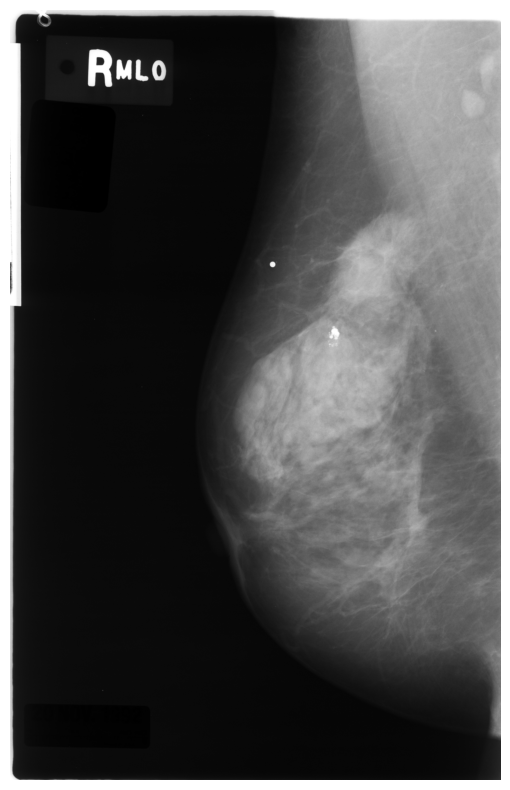

In [12]:
filename = f"{item['patient_id']}@{item['image_id']}.png"
filename = os.path.join(
    img_dir, f"{item['dataset']}/cleaned_images/", filename
)
src_img = cv2.imread(filename)
assert src_img is not None
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(src_img)
print(src_img.shape)

In [13]:
# build the model from a config file and a checkpoint file
model: nn.Module = get_model(cfg, checkpoint, device=device)
if preview_model:
    print(model)

# apply transform and perpare data
transforms = Compose(
    [TRANSFORMS.build(t) for t in cfg.test_dataloader.dataset.pipeline])
data = transforms(item)
src_img = copy.deepcopy(data['inputs']).numpy().transpose(1, 2, 0)
data = model.data_preprocessor(default_collate([data]), False)
target_layers = ["backbone.layers.6.activate"]
# build target layers
if target_layers:
    target_layers = [
        get_layer(layer, model) for layer in target_layers
    ]
else:
    target_layers = get_default_target_layers(model, vit_like, num_extra_tokens)

# init a cam grad calculator
use_cuda = ('cuda' in device)
cam = init_cam(method, model, target_layers, use_cuda,
                partial(reshape_transform, model=model, vit_like=vit_like, num_extra_tokens=num_extra_tokens))

# warp the target_category with ClassifierOutputTarget in grad_cam>=1.3.7,
# to fix the bug in #654.
targets = None
if target_category:
    grad_cam_v = pkg_resources.get_distribution('grad_cam').version
    if digit_version(grad_cam_v) >= digit_version('1.3.7'):
        from pytorch_grad_cam.utils.model_targets import \
            ClassifierOutputTarget
        targets = [ClassifierOutputTarget(c) for c in target_category]
    else:
        targets = target_category

# calculate cam grads and show|save the visualization image
grayscale_cam = cam(
    data['inputs'],
    targets,
    eigen_smooth=eigen_smooth,
    aug_smooth=aug_smooth)
show_cam_grad(
    grayscale_cam, src_img, title=method, out_path=save_path)
mmcv.imwrite(src_img, str("./input.jpg"))

Loads checkpoint by local backend from path: pretrained/efficientnet-b3-gencam.pth


/home/islab/DATA/venv/mmbreast/lib/python3.12/site-packages/mmengine/runner/checkpoint.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename

BreastCancerAuxCls(
  (data_preprocessor): ClsDataPreprocessor()
  (backbone): EfficientNet(
    (layers): ModuleList(
      (0): ConvModule(
        (conv): Conv2dAdaptivePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (activate): Swish()
      )
      (1): Sequential(
        (0): InvertedResidual(
          (drop_path): Identity()
          (depthwise_conv): ConvModule(
            (conv): Conv2dAdaptivePadding(40, 40, kernel_size=(3, 3), stride=(1, 1), groups=40, bias=False)
            (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (activate): Swish()
          )
          (se): SELayer(
            (global_avgpool): AdaptiveAvgPool2d(output_size=1)
            (conv1): ConvModule(
              (conv): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (activate): Swish()
            )
            (conv

True